# CarND-Vehicle-Detection-Images
---

In [17]:
import numpy as np
import cv2
import glob
import time
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog

%matplotlib qt
%matplotlib inline

### Data Sets

In [18]:
#Original big data set
#car_list = ['./vehicles/GTI_Far/*.png', './vehicles/GTI_Left/*.png', './vehicles/GTI_MiddleClose/*.png',
#            './vehicles/GTI_Right/*.png', './vehicles/KITTI_extracted/*.png' ]

#not_car_list = ['./non-vehicles/Extras/*.png', './non-vehicles/GTI/*.png']

#Small data set
car_list = ['./vehicles_smallset/cars1/*.jpeg', './vehicles_smallset/cars2/*.jpeg', 
            './vehicles_smallset/cars3/*.jpeg']
not_car_list = ['./non-vehicles_smallset/notcars1/*.jpeg', './non-vehicles_smallset/notcars2/*.jpeg',
               './non-vehicles_smallset/notcars3/*.jpeg']

cars = []
for clist in car_list:
    images = glob.glob(clist)
    cars_in_list = []
    for image in images:
        cars_in_list.append(image)
    cars = cars + cars_in_list
    
notcars = []
for notclist in not_car_list:
    images = glob.glob(notclist)
    not_cars_in_list = []
    for image in images:
        not_cars_in_list.append(image)
    notcars = notcars + not_cars_in_list
    

#JPG big data set
car_list_big = ['./vehicles_smallset/cars/*.jpg']
not_car_list_big = ['./non-vehicles_smallset/notcars/*.jpg']

cars_big = []
for clist in car_list_big:
    images = glob.glob(clist)
    cars_in_list_big = []
    for image in images:
        cars_in_list_big.append(image)
    cars_big = cars_big + cars_in_list_big
    
notcars_big = []
for notclist in not_car_list_big:
    images = glob.glob(notclist)
    not_cars_in_list_big = []
    for image in images:
        not_cars_in_list_big.append(image)
    notcars_big = notcars_big + not_cars_in_list_big
    
#Randomly select samples from JPG big data set
cars_big = random.sample(cars_big, len(notcars))
notcars_big = random.sample(notcars_big, len(cars))

#Merge both data sets
cars = cars + cars_big
notcars = notcars + notcars_big

### Features Definition

In [19]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features


# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        #image = image*255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

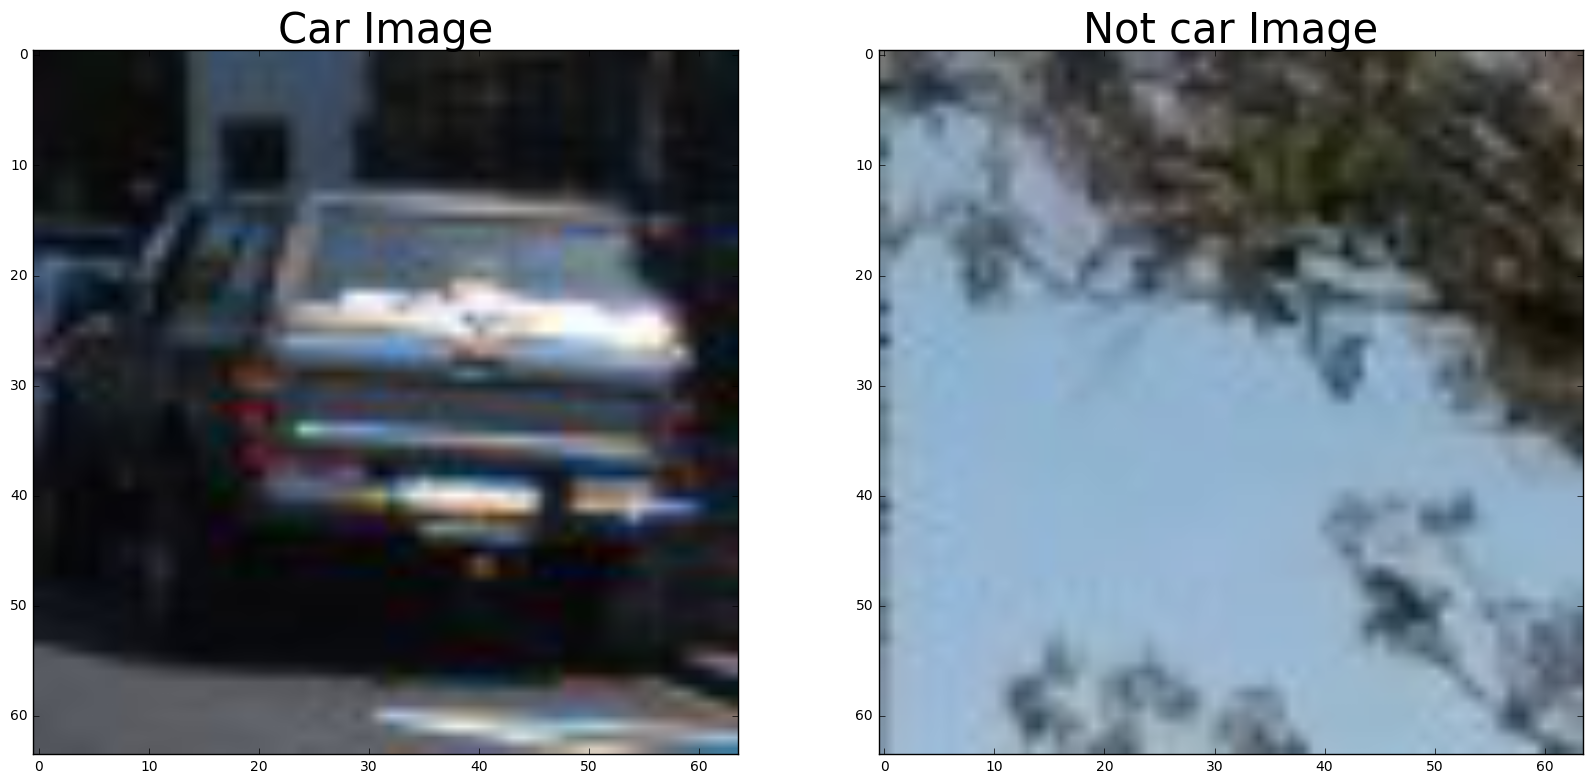

In [20]:
car_test = mpimg.imread(cars[35])
notcar_test = mpimg.imread(notcars[45])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car_test)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(notcar_test)
ax2.set_title('Not car Image', fontsize=30)

### Features Extraction

In [5]:
#sample_size = 1000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


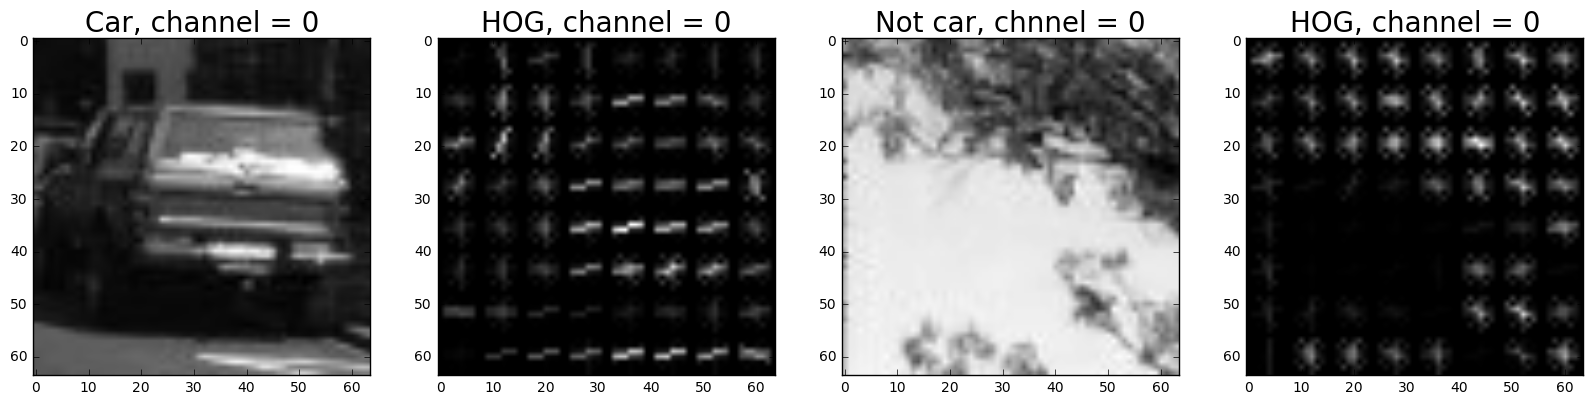

In [6]:
ch = 0
car_test_image = cv2.cvtColor(car_test, cv2.COLOR_RGB2YUV)
features_hog, hog_car= get_hog_features(car_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)
notcar_test_image = cv2.cvtColor(notcar_test, cv2.COLOR_RGB2YUV)
features_nothog, hog_notcar= get_hog_features(notcar_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(car_test_image[:,:,ch], cmap='gray')
ax1.set_title('Car, channel = '+str(ch), fontsize=20)
ax2.imshow(hog_car, cmap='gray')
ax2.set_title('HOG, channel = '+str(ch), fontsize=20)

ax3.imshow(notcar_test_image[:,:,ch], cmap='gray')
ax3.set_title('Not car, chnnel = '+str(ch), fontsize=20)
ax4.imshow(hog_notcar, cmap='gray')
ax4.set_title('HOG, channel = '+str(ch), fontsize=20)

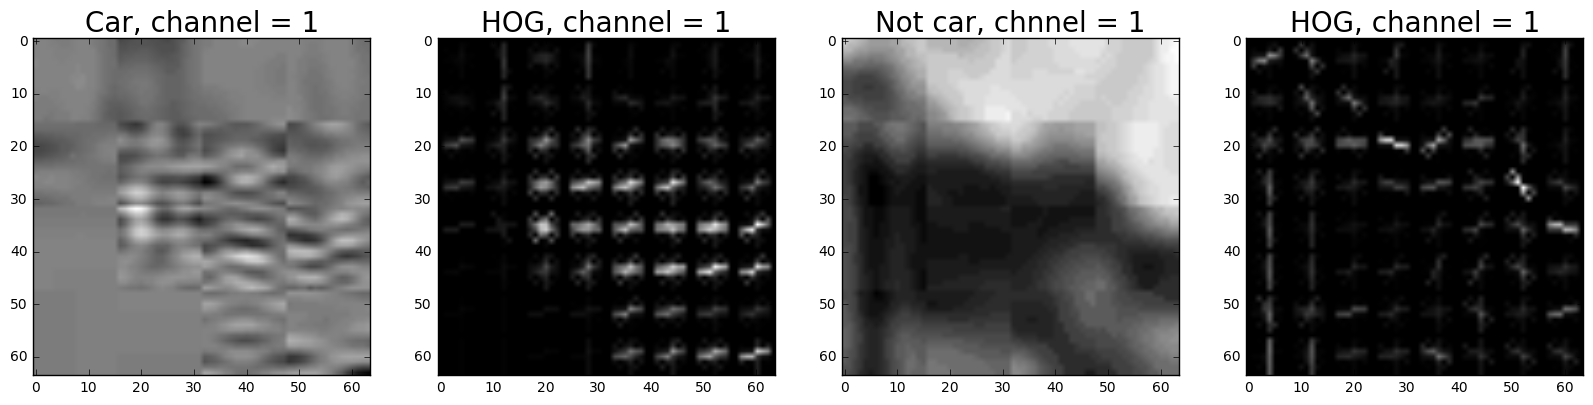

In [7]:
ch = 1
car_test_image = cv2.cvtColor(car_test, cv2.COLOR_RGB2YUV)
features_hog, hog_car= get_hog_features(car_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)
notcar_test_image = cv2.cvtColor(notcar_test, cv2.COLOR_RGB2YUV)
features_nothog, hog_notcar= get_hog_features(notcar_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(car_test_image[:,:,ch], cmap='gray')
ax1.set_title('Car, channel = '+str(ch), fontsize=20)
ax2.imshow(hog_car, cmap='gray')
ax2.set_title('HOG, channel = '+str(ch), fontsize=20)

ax3.imshow(notcar_test_image[:,:,ch], cmap='gray')
ax3.set_title('Not car, chnnel = '+str(ch), fontsize=20)
ax4.imshow(hog_notcar, cmap='gray')
ax4.set_title('HOG, channel = '+str(ch), fontsize=20)

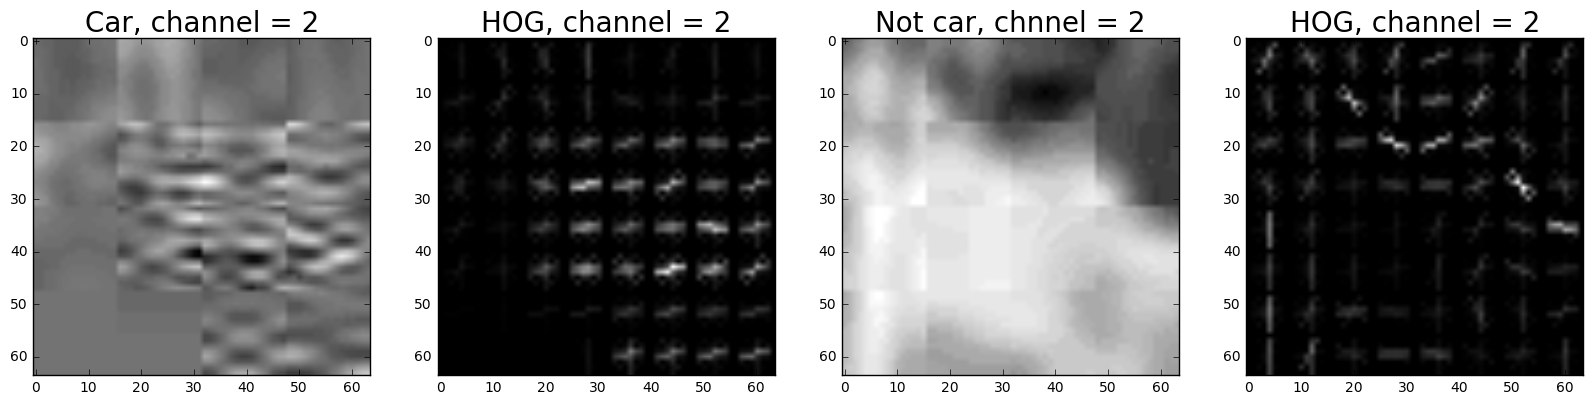

In [8]:
ch = 2
car_test_image = cv2.cvtColor(car_test, cv2.COLOR_RGB2YUV)
features_hog, hog_car= get_hog_features(car_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)
notcar_test_image = cv2.cvtColor(notcar_test, cv2.COLOR_RGB2YUV)
features_nothog, hog_notcar= get_hog_features(notcar_test_image[:,:,ch], 9, 8, 2, vis=True, feature_vec=True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(car_test_image[:,:,ch], cmap='gray')
ax1.set_title('Car, channel = '+str(ch), fontsize=20)
ax2.imshow(hog_car, cmap='gray')
ax2.set_title('HOG, channel = '+str(ch), fontsize=20)

ax3.imshow(notcar_test_image[:,:,ch], cmap='gray')
ax3.set_title('Not car, chnnel = '+str(ch), fontsize=20)
ax4.imshow(hog_notcar, cmap='gray')
ax4.set_title('HOG, channel = '+str(ch), fontsize=20)

### Trainning and Fitting

In [9]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 17676
10.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


### Slinding Window Method

In [10]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Search single image features using sliding window technique

In [11]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='LUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Heat map calculation

In [12]:
from scipy.ndimage.measurements import label

#box_list = hot_windows
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def heat_map(image, hot_windows):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

### Test Vehicle Detection

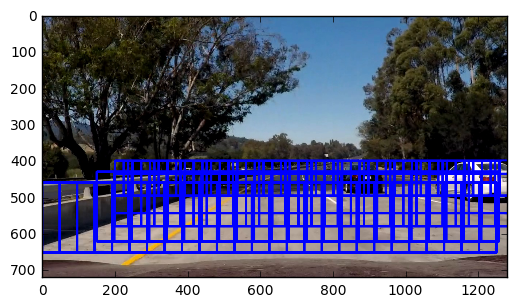

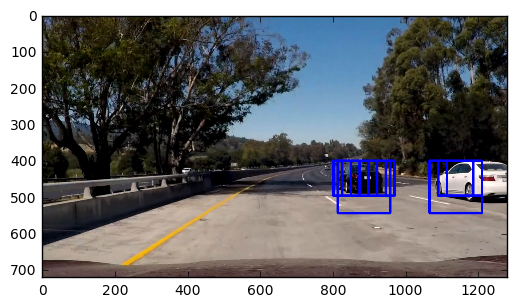

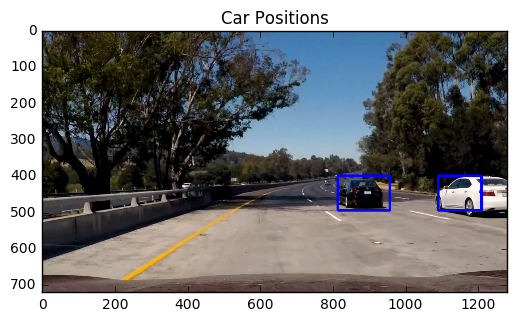

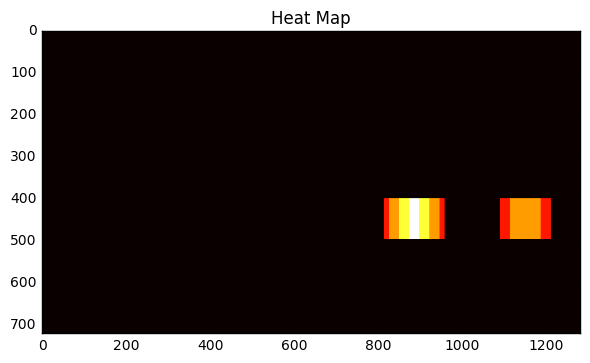

In [13]:
image = mpimg.imread('./frames/test_video_1028.jpg')

windows = slide_window(image, x_start_stop=[200, None], y_start_stop=[400, 500], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[200, None], y_start_stop=[400, 600], 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[150, None], y_start_stop=[430, 630], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 660], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)  

fig1 = plt.figure()
plt.imshow(window_img)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

fig2 = plt.figure()
plt.imshow(window_img)

draw, heatmap = heat_map(image, hot_windows)
fig3 = plt.figure()
plt.imshow(draw)
plt.title('Car Positions')

fig4 = plt.figure()
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig4.tight_layout()

### Test with multiple frames

In [14]:
#Video converted to images in ./test_video
list_of_images = glob.glob('./frames/*.jpg')
sorted_list = sorted(list_of_images)

frames = 10
total_boxes = []
time_initial = time.time()
for i in range(0,int(len(sorted_list)/frames)):
    boxes = []
    for images in sorted_list[frames*i: frames*(i+1)-1]:
        img = mpimg.imread(images)
        #print(10*i, 10*(i+1)-1)
        boxes_per_frame = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        
    boxes = boxes + boxes_per_frame
    print('Number of frames = '+str(10*(i+1)))
    print('Time = '+str(time.time() - time_initial))
        #print(images)
    total_boxes.append(boxes)
print(total_boxes)

Number of frames = 10
Time = 15.858046054840088
[[((800, 400), (896, 496)), ((824, 400), (920, 496)), ((848, 400), (944, 496)), ((872, 400), (968, 496)), ((1088, 400), (1184, 496)), ((1112, 400), (1208, 496)), ((812, 400), (956, 544)), ((1064, 400), (1208, 544))]]


In [15]:
counter = 0
i = 0
for box in total_boxes:
    for images in sorted_list[frames*i: frames*(i+1)]:
        img = mpimg.imread(images)
        draw, heatmap = heat_map(img, box)
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        cv2.imwrite('frames/test_video_000'+str(counter)+'.jpg',draw)       
        counter = counter + 1
        if (counter%100 == 0):
            print('Frame: '+str(counter))
            #print(sorted_list[frames*i: frames*(i+1)])
    i = i+1

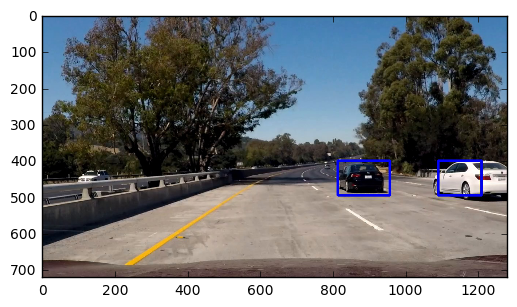

In [16]:
plt.imshow(mpimg.imread('./frames/test_video_0001.jpg'))